# The Plan

0. Make sure you have all tools installed. mafft, trimal, iqtree at the very least. 
   - use `conda env create -f ./conda_environment.yaml` to create this environment and re-open jupyter inside the environment if you haven't already.
1. Get a set of sequences to build a tree of.
   - for example from the 1kP project, a paper you found, or from blast.
   - Subset sequences if there are too many.
   - Do you have an outgroup to root your tree on? (unless you won't root your tree)
   - Do you have trusted or verified sequences to make sense of the different clades you may get in your tree?
2. Align these to each other.
   - using mafft or another aligner like clustalw, tcoffee or prank.
3. Trim the alignment, removing gaps.
   - with trimAL, optimise trimming to both make your tree building faster and more reliable.
4. Build a fast phylogentic tree.
   - with `fasttree`, or with `iqtree --fast`
5. Build a thorough phylogenetic tree.
   - We combine substitution model fitting and tree building in IQtree.
6. Visualise and share your tree
   - [iToL](http://www.iqtree.org/doc/Frequently-Asked-Questions#how-do-i-interpret-ultrafast-bootstrap-ufboot-support-values)
   
## Annotate and log

A jupy notebook like this, is your labjournal for doing research on the computer. In here you keep a record of 
 - what files you use
 - how you made new files
 - where you stored these
 - etcetera.
 
You do this just by writing the code and keeping the output saved in here. However, one thing is not kept automatically, and that is the choices you make. Hence for transparent and propper science, it is vital that you make this notebook your own, by writing all observations, desicions etcetera in here.

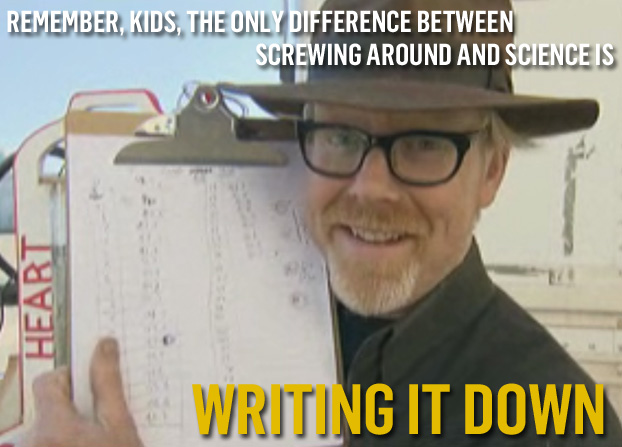


Describe how you got the sequences you're making a tree of, why you got those sequences there, and what question you are trying to answer by making this tree.

# 1. Composing your fasta

Let's look at what we have

In [ ]:
tree

Store the sequences you want to make a tree of in the data directory and make the inseq variable the name of your input fasta without the extention:

In [ ]:
inseq=

Let's look at the first ten lines of your fasta to double-check.

In [ ]:
head data/$inseq.fasta

Check the nr. of sequences in your fasta file:

In [ ]:
grep '>' data/$inseq.fasta -c

If the nr of sequences in your input file is too big, consider subsetting them. A tree of more than a couple of hundred sequences is very hard to browse through anyway. Also, more sequences is not per say more reliable. Longer sequences often is.

I present you here with two ways of subsetting, a random one (easy but not so good) and a systematic one (more work but better). If you're up for the systematic approach, skip the random subsetting section and move ahead to section 1.2.

Finally, you may also combine both methods: taking a random set, then adding a few desired species afterwards.

## 1.1 Random subsetting
select a number `n` of sequences you'd like to use. We'll pick a random set of these. The random selection of names is stored in a new file.

In [ ]:
n=700
grep '>' data/$inseq.fasta | tr -d '>' | shuf | head -n $n > data/"$inseq"_random-"$n".txt

Now double check how many names are in there and what the file looks like

In [ ]:
wc -l ./data/"$inseq"_random-"$n".txt

In [ ]:
head data/"$inseq"_random-"$n".txt

Now we'll need to make sure your fasta is linear and not interleaved. Or in other words: the sequences must span only one line no matter how long the sequence is, not multiple lines of a fixed width.

Convert your fasta to a linear format like so:

In [ ]:
cat $inseq.fasta \
  | awk '/^>/ {printf("%s%s\n",(N>0?"\n":""),$0);N++;next;} {printf("%s",$0);} END {printf("\n");}' \
  > "$inseq"_linear.fasta

In [ ]:
grep -f data/"$inseq"_random-"$n".txt "$inseq"_linear.fasta > data/"$inseq"_random-"$n".fasta

Again, double checking that we selected `$n` sequences in our fasta file and checking what it looks like

In [ ]:
grep '>' -c data/"$inseq"_random-"$n".fasta

In [ ]:
head data/"$inseq"_random-"$n".fasta

## 1.2 systematic subsetting.

If your data set has some systamic naming of sequences, or of species/genus names, it would be good to subset based on those. How to do this, completely depends on the formatting of your specific dataset. Here I examplify this for the 1kP dataset.

The 1kP dataset works with 4 letter codes for RNA assembled transcripts, and with 5 letter codes for transcriptes derived from assembled genomes. The former can be browsed [here](http://www.onekp.com/samples/list.php).

The nice thing about the 1kP dataset, is that it has plants categorised in clades, families and species. You can use this data to evenly select species from both early and late branching clades and get a nice overview of plant evolution.

I propose to make a file with the 'search criteria' that your sequences need to match. That could be species names, certain codes, etcetera. Next, use grep to get all sequence names that match those search criteria, and then extract the sequences.

Finally, I'm just making sure that all sequences names are unique.

In [ ]:
grep '^>' data/$inseq.fasta | grep -f ./data/selection-v1 | sort | uniq > ./data/"$inseq"_selection-v1.txt

Now extract the sequences that match those sequence names

In [ ]:
cat $inseq.fasta \
  | awk '/^>/ {printf("%s%s\n",(N>0?"\n":""),$0);N++;next;} {printf("%s",$0);} END {printf("\n");}' \
  > "$inseq"_linear.fasta

In [ ]:
grep -f ./data/"$inseq"_selection-v1.txt "$inseq"_linear.fasta > data/"$inseq"_selection-v1.fasta

## 1.3 add guide sequences
If you have versions of your sequence of special interest, or functionally verified ones, be sure to add them! 

I imagine you have your guide sequences named something like `data/guide_sequences_v1.fasta` Combine the two files like so and update the `$inseq` variable with the new name if you are done in this section.

In [ ]:
# for the random workflow
cat data/guide_sequences-v1.fasta data/"$inseq"_random-"$n".fasta > data/"$inseq"_random-"$n"_guide-v1.fasta

In [ ]:
# for the selection workflow
cat data/guide_sequences-v1.fasta data/"$inseq"_selection-v1.fasta > data/"$inseq"_selection-v1_guide-v1.fasta

In [ ]:
# for the random workflow
inseq="$inseq"_random"$n"_guidev1
echo $inseq

In [ ]:
# for the selection workflow
inseq="$inseq"_selection-v1_guide1v1
echo $inseq

In [ ]:
head data/$inseq.fasta

# 2. Aligning

Now we have our fasta file with a feasible amount of sequences. Next step is aligning these. While this may seem trivial, the method of aligning can actually influence your end results quite a bit. Roughly speaking there is several alignment algorithms:

1. progressive
   - mafft
   - clustal?
2. pair-wise
   - mafft
   - ...
3. ...

Especially for bigger datasets, I prefer mafft for it is simply very fast and gave me good results in the past. But by all means try more ways if you get odd results.

If you have a good idea of what you're doing, and you want to run multiple alignments in a loop and go have lunch, have a look at section 2.2.

## 2.1 running alignments (one by one).

### 2.1.1. MAFFT [online](https://mafft.cbrc.jp/alignment/server/)

If you find mafft options and parameters confusing, and/or you have difficulty making alignments, 
then you may tre to use the online service [here](https://mafft.cbrc.jp/alignment/server/). 
The online MAFFT service does a good job at explaining the parameters and has a nice visualisation as well!
So read the webpage, and choose your options and parameters aided by the explanations in the webpage. When you submit your job, the mafft command issued in the background is actually shown to you! Hence you can copy paste that command here if you'd like. That's especially useful when the server is under high load, in this notebook you may choose to use all threads available on your computer `--threads $(nproc)`.

Using the MSAviewer that you can open after running your alignment on this server, you can even interactivelly trim. From a reproducibility/scaling point of view, this is not ideal, but to get a feeling for what you are doing, it is very usefull. Just make sure you keep a record of what you do, and keep intermediate results with clear names.

### 2.1.2 MAFFT local
I'll start with showing you my go-to approach. First, have a look at the manual. 

Next I'll make a directory to store the untrimmed (hence raw) alignments and run the alignment on all available CPU cores.

I like to do this in 'if loops' to prevent re-doing things unnecessarily.

In [ ]:
# If jupyter cannot find mafft, but it is installed via conda, try this pragmatic fix:
#conda activate phylogenetics

In [ ]:
mafft --help

Linsi is probably the most acurate mafft setting (as declared by the MAFFT authors). It is turned off by default in normal or auto mafft for alignments bigger than 200 sequences. Typically, it only takes a couple of minutes so I don't mind the wait. Building a tree takes a lot longer so these extra minutes are a sensible investment to me.

In [ ]:
#rm "./data/alignments_raw/$inseq"_aligned-mafft-linsi.fasta
if    [ ! -d ./data/alignments_raw/ ]
then  mkdir  ./data/alignments_raw
fi
if    [ ! -f "./data/alignments_raw/$inseq"_aligned-mafft.fasta ]
then  linsi --thread $(nproc) data/$inseq.fasta > ./data/alignments_raw/"$inseq"_aligned-mafft-linsi.fasta
fi

In [ ]:
ls ./data/alignments_raw

In [ ]:
head ./data/alignments_raw/"$inseq"_aligned-mafft-linsi.fasta

### 2.1.2 Other aligners, comming up.

## 2.2 Running many allignments in loops.

# 3. Alignment trimming

Odds are, your alignment is quite gappy which may confuse tree building algorithms. Often it is better to remove gappy columns in your alignment. Let's have a look at this with `trimAl`. Short for 'trim alignment' (I guess). No Artificial intelegence stuff going on here.

As always, have a look at the help page.

In [ ]:
trimal -h

## 3.1 automated trimming
Now let's go with the automated algorith of `trimAl` first and inspect the results.

I'm running this in a loop that will process all your alignments of the last step simultaneously. Try not to create too many.

In [ ]:
if    [ ! -d data/alignments_trimmed ]
then  mkdir  data/alignments_trimmed 
fi

# define appendix only once here:
trimappendix='trim-auto'

for a in "data/alignments_raw/$inseq"_aligned*.fasta
do  appendix=$(echo $a | cut -d '/' -f 3- | sed "s/$inseq\_//" | sed "s/.fasta//")
    if    [ ! -f data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".fasta ]
    then  echo "trimming alignment $a"
          sed -i 's/ /_/g' $a
          nice trimal -in $a   \
                      -out data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".fasta \
                      -automated1 \
                      -htmlout data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".html &
    fi
done
wait

You can evaluate the trimming in the webpage that trimal made. Browse in the jupyter file browser to: 

> data/alignments_trimmed/...trim-auto.html'

the webpage should open in your browser and you can check how many sequences and collumns have been retained, and see exactly which ones. If you are contect, proceed to tree building!

### 3.2 Tweak trimming parameters

Alternatively, you may tweak your own trimming parameters like so. 

Everytime I change parameters, I change the variable `$trimappendix` to reflect those changes. Second, I explain briefly in a text cell why I chose to do so.

In [ ]:
if    [ ! -d data/alignments_trimmed ]
then  mkdir  data/alignments_trimmed 
fi

# define appendix only once here:
trimappendix='trim-gt4-seq90-res8'


for a in "data/alignments_raw/$inseq"_aligned*.fasta
do  appendix=$(echo $a | cut -d '/' -f 3- | sed "s/$inseq\_//" | sed "s/.fasta//")
    if    [ ! -f data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".fasta ]
    then  echo "trimming alignment $a"
          sed -i 's/ /_/g' $a
          trimal -in $a   \
                 -out data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".fasta \
                 -gt .4 \
                 -seqoverlap 80 \
                 -resoverlap 0.7 \
                 -htmlout data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".html
    fi
done

In [ ]:
ls data/alignments_trimmed

In [ ]:
head data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".fasta 

# 4. Fast tree building
Here we'll make fast trees: not acurate, no bootstraps, but fast. This gives us an idea of the output and how we will process it. Building 'propper' trees can take days sometimes weeks, so it's better to be sure you have all sequences in there you want before you start. 

I use two ways to make thise fast trees, first with a program called `fasttree` and second with the programm `iqtree` with the `-fast` parameter. My gut feeling is that the latter is a bit more acurate but takes a couple of minutes. Fasttree takes seconds.

I arbitrarily consider trees to be analyses and not data, hence I store these in the `analyses` directory.

Since these trees run fast (just take a second to consider how rediculous that sounds) I propose to run these in loops again, taking all the trimmed alignments that were made earlier. The trees run in parallel on one CPU. If you're running many trees (way more than you have computing cores) then don't run these in the background. Practically, that means removing the `&` character almost at the end of the loop.

## 4.1 fasttree

In [ ]:
for a in data/alignments_trimmed/"$inseq"_aligned*.fasta
do  echo "making a fasttree of file $a"
    appendix=$(echo $a | cut -d '/' -f 3- | sed "s/$inseq\_//" | sed "s/.fasta//")
    echo $appendix
    
    if   [ ! -d   analyses/"$inseq"_fasttrees/"$appendix" ]
    then mkdir -p analyses/"$inseq"_fasttrees/"$appendix"
    fi
    
    prefix=analyses/"$inseq"_fasttrees/"$appendix"/"$inseq"_"$appendix"_fasttree
    if   [ ! -f "$prefix".tree ]
    then nice fasttree -log "$prefix".log \
                       $a \
                       >  "$prefix".tree \
                       2> "$prefix".stderr &
    fi
done
wait

In [ ]:
tail analyses/"$inseq"_fasttrees/*/*fasttree.stderr

In [ ]:
tree analyses/"$inseq"_fasttrees/

## 4.2 IQtree -fast

And here is the same but for running iqtree. I picked some random model here, but substitute it by anything you like better or have good experience with it the past.

In [ ]:
for a in data/alignments_trimmed/"$inseq"_aligned*.fasta
do  echo "making a iqtree fast tree of file $a"
    appendix=$(echo $a | cut -d '/' -f 3- | sed "s/$inseq\_//" | sed "s/.fasta//")
    echo $appendix
    if   [ ! -d   analyses/"$inseq"_fasttrees/"$appendix" ]
    then mkdir -p analyses/"$inseq"_fasttrees/"$appendix"
    fi
    
    iqprefix=analyses/"$inseq"_fasttrees/"$appendix"/"$inseq"_"$appendix"_iqtree-fast
    if   [ ! -f "$iqprefix".iqtree ]
    then nice iqtree -s $a -fast \
                     -m 'LG+R7' \
                     -pre "$iqprefix" \
                     > "$iqprefix".stdout \
                     2> "$iqprefix".stderr &
    fi
done
wait

## 4.3 Visualise your fast trees. 

To visualise your trees, you perhaps already have something installed like mega, seaview, etc. Otherwise you can upload the tree file to [iToL](https://itol.embl.de/) (my prefered method) or any other website that visualises trees. See section 6 for uploading your trees to iToL.

Alternativelly, we can try to get a quick snapshot here in the notebook:

### 4.3.1 Tree comparisons 

You may want to run a quick comparison table like so:

In [ ]:
ete3 compare --unrooted -t ./analyses/MYBs-nina_fasttrees/*/*fasttree.tree -r ./analyses/MYBs-nina_fasttrees/*/*iqtree-fast.treefile

Collumns abbreviations:

* source target tree used
* ref reference tree used to compare with
* eff.size Effective tree size used for comparisons (after pruning not shared items)
* nRF Normalized Robinson-Foulds distance (RF/maxRF)
* RF Robinson-Foulds symmetric distance
* maxRF maximum Robinson-Foulds value for this comparison
* %src_br frequency of edges in target tree found in the reference (1.00 = 100% of branches are found)
* %ref_br frequency of edges in the reference tree found in target (1.00 = 100% of branches are found)
* subtrees Number of subtrees used for the comparison (applies only when duplicated items are use to decomposed target trees)
* treekoD Average distance among all possible subtrees in the original target trees to the reference tree (TreeKO speciation distance).

Big numbers or fractions are usually not a good sign, but can happen. Just be extra carefull before drawing any conclusions.

## 5. Building trees with IQtree 

Finally, we're at the stage to build propper maximum likelyhood phylogenetic trees! Based on your previous results, you should have one or two trimmed alignments you want to make a tree of. There is several choices to make still: a model of evolution and a bootstrapping method.

**modelfinder**

IQtree is a state-of-the art tree buildling program, which has a model finder algorithm included! This can take a couple of hours, so be sure to do this only once. There is two model finder options, a quick one with some often used models: `-m TEST` or an extended modelfinder, using more models of evolution and substitution: `-m MFP`. I recommend the latter. Once you have your best-fit model (for example: 'LG+R7') then use this model when you build more trees from the same alignment: `-m 'LG+R7'`

**bootstrapping**

Normal or 'non-parametric' bootstrapping can take quite a long time; I have had trees running for weeks. Hence there is alternatives that are a lot faster but might over or underestimate the bootstrap values if your alignment doesn't fit your model well. To use 'normal bootstraps' the minimum is 100. That's why I like to to 200 to be safe, by adding the option `-b 200`.

Alternativelly, there is the 'ultrafast bootstrap' option in IQtree. The minumum for this is 1000 bootstraps, so I'd like to do double by including the parameter: `-bb 2000`. Additionally, I highly recommend also running the approximate likelyhood ratio test for 2000 bootstraps at the same time by including parameters `-alrt 2000`. This adds a minimal amount of run time and makes interpretation of your tree a lot more reliable.

As the [IQtree FAQ](http://www.iqtree.org/doc/Frequently-Asked-Questions#how-do-i-interpret-ultrafast-bootstrap-ufboot-support-values) says: typically you start believing a clade when the ultra fast bootstraps => 95 and alrt => 80. Interpretation of these values is not linear like 'normal' bootstrap, hence if you lower the threshold of ultrafast bootstraps to 90, you will likely enormously overestimate your results. 

**other command-line options**

In the commandline I wrote below, I instruct iqtree to use no more CPU cores than your computer has, but also to find the optimum amount of cores (more is not always better). Second, a prefix is defined to store the different trees that IQtree wil make.

**More info**
* iqtree tutorial: http://www.iqtree.org/doc/Tutorial
* aLRT: https://www.ncbi.nlm.nih.gov/pubmed/16785212





## running IQtree

Now these are all trimmed alignments you have available. 
Choose one to start with (based on your fasttrees or inspections of your alignments).

Make sure that 
1. the path to this alignment is the variable `$a` 
2. you choose an appendix based on your iqtree settings

In [ ]:
ls data/alignments_trimmed/"$inseq"_aligned*fasta

In [ ]:
a=data/alignments_trimmed/"$inseq"_aligned....fasta

#iqpendix='iqtree-b200'
iqpendix='iqtree-bb2000-alrt2000'

echo "making a tree of file $a"
echo "The first lines of alignment $a look like this"
head $a

file_appendix=$(echo $a | cut -d '/' -f 3- | sed "s/$inseq\_//" | sed "s/.fasta//")
echo "Making a directory $file_appendix to store trees (name based on alignment filename)"

if   [ ! -d    analyses/"$inseq"_trees/"$file_appendix" ]
then mkdir -p  analyses/"$inseq"_trees/"$file_appendix" 
fi

iqprefix=analyses/"$inseq"_trees/"$file_appendix"/"$inseq"_"$file_appendix"_"$iqpendix"
if   [ ! -f analyses/"$inseq"_trees/"$file_appendix"/"$inseq"_"$file_appendix"_iqtree-bb1000.tree ]
then nice iqtree -s $a \
                 -m MFP \
                 -bb 2000 \
                 -alrt 2000 \
                 -nt AUTO \
                 -ntmax $(nproc)  \
                 -pre  "$iqprefix" \
                 2>   "$iqprefix".stderr \
                 >    "$iqprefix".stdout
#    cat "$iqprefix".out | mail -s IQtree_run your_e-mail@email.com
fi

In [ ]:
ls $iqprefix* -1

You can have a look at the last lines of your log file like this:

In [ ]:
tail -n 40 $iqprefix.log

Are you content with your tree? Great news! If you want to do another run, I recommend copying the cell above and editing the copy. That way you keep the code for all trees you made. Don't forget to explain what you observed, why you're making a new tree, and what you're changing (remember this is your labjournal). 

# tree storage

For tree storage and sharing, I have yet to encounter a better tool than EMBLs [iToL](https://itol.embl.de/). It's a great interface for exploring and sharing trees with colleagues. You can browse to the treefile IQtree created on your computer and upload it to iToL. Alternativelly, you can copy paste the contents of the file to iToL. Make sure to keep the original filename as well! This file name now contains a brief summary of how this tree was made.